In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from scipy.stats import lognorm
import statsmodels.api as sm

In [4]:
plays_df = pd.read_csv('../../data/derived/plays/inf_gb_with_throw_1b_df.csv').drop(columns=['Unnamed: 0'])
play_direction_df = pd.read_csv('../../data/derived/plays/ball_directions.csv').drop(columns=['Unnamed: 0'])

throw_time_df = plays_df.merge(play_direction_df, on=['game_str', 'play_id'], how='inner')
throw_time_df = throw_time_df[['game_str', 'play_id', 'play_per_game', 'game_event_index', 'player_position', 'throw_time', '1b_receive_time', 'ball_direction']]

game_info_df = pd.read_csv('../../data/combined/game_info.csv').drop(columns=['Unnamed: 0'])

pos_dict = {1:'pitcher', 2:'catcher', 3:'first_base', 4:'second_base', 5:'third_base', 6:'shortstop'}
throw_time_df = throw_time_df.merge(game_info_df, on=['game_str', 'play_per_game'], how='inner')
throw_time_df['player_id'] = throw_time_df.apply(lambda row: row[pos_dict[row['player_position']]], axis=1)
throw_time_df = throw_time_df[['game_str', 'play_per_game', 'play_id', 'player_id', 'player_position', 'throw_time', '1b_receive_time', 'ball_direction']]

ball_pos_df = pd.read_csv('../../data/combined/ball_pos.csv').drop(columns=['Unnamed: 0'])

def create_shifted_columns(throw_time_df, shift_amount):
    new_df = throw_time_df[['game_str', 'play_id', 'timestamp']].copy()
    column_name = f'throw_time_{shift_amount + 1}'
    new_df[column_name] = new_df['timestamp'].shift(-shift_amount)
    return new_df

throw_time_2_df = create_shifted_columns(ball_pos_df, 1)
throw_time_3_df = create_shifted_columns(ball_pos_df, 2)

throw_time_df['throw_time_2'] = throw_time_df.merge(throw_time_2_df, how='inner', left_on=['game_str', 'play_id', 'throw_time'], right_on=['game_str', 'play_id', 'timestamp'])['throw_time_2']
throw_time_df['throw_time_3'] = throw_time_df.merge(throw_time_3_df, how='inner', left_on=['game_str', 'play_id', 'throw_time'], right_on=['game_str', 'play_id', 'timestamp'])['throw_time_3']


throw_time_df = throw_time_df.merge(ball_pos_df, left_on=['game_str', 'play_id', 'throw_time'], right_on=['game_str', 'play_id', 'timestamp'], how='inner')
throw_time_df.rename(columns={
    'ball_position_x': 'ball_position_x_start',
    'ball_position_y': 'ball_position_y_start',
    'ball_position_z': 'ball_position_z_start',
    }, inplace=True)
throw_time_df.drop(columns='timestamp', inplace=True)

throw_time_df = throw_time_df.merge(ball_pos_df, left_on=['game_str', 'play_id', 'throw_time_2'], right_on=['game_str', 'play_id', 'timestamp'], how='inner')
throw_time_df.rename(columns={
    'ball_position_x': 'ball_position_x_2',
    'ball_position_y': 'ball_position_y_2',
    'ball_position_z': 'ball_position_z_2',
    }, inplace=True)
throw_time_df.drop(columns='timestamp', inplace=True)

throw_time_df = throw_time_df.merge(ball_pos_df, left_on=['game_str', 'play_id', 'throw_time_3'], right_on=['game_str', 'play_id', 'timestamp'], how='inner')
throw_time_df.rename(columns={
    'ball_position_x': 'ball_position_x_3',
    'ball_position_y': 'ball_position_y_3',
    'ball_position_z': 'ball_position_z_3',
    }, inplace=True)
throw_time_df.drop(columns='timestamp', inplace=True)

throw_time_df = throw_time_df.merge(ball_pos_df, left_on=['game_str', 'play_id', '1b_receive_time'], right_on=['game_str', 'play_id', 'timestamp'], how='inner')
throw_time_df.rename(columns={
    'ball_position_x': 'ball_position_x_end',
    'ball_position_y': 'ball_position_y_end',
    'ball_position_z': 'ball_position_z_end',
    }, inplace=True)
throw_time_df.drop(columns='timestamp', inplace=True)

throw_time_df['total_throw_distance'] = np.sqrt((throw_time_df['ball_position_x_end'] - throw_time_df['ball_position_x_start'])**2 + 
                               (throw_time_df['ball_position_y_end'] - throw_time_df['ball_position_y_start'])**2)

throw_time_df['distance_3D'] = np.sqrt((throw_time_df['ball_position_x_end'] - throw_time_df['ball_position_x_start'])**2 +
                                 (throw_time_df['ball_position_y_end'] - throw_time_df['ball_position_y_start'])**2 +
                                    (throw_time_df['ball_position_z_end'] - throw_time_df['ball_position_z_start'])**2)

throw_time_df['throw_velo_mph'] = np.sqrt((throw_time_df['ball_position_x_2'] - throw_time_df['ball_position_x_3'])**2 +
                               (throw_time_df['ball_position_y_2'] - throw_time_df['ball_position_y_3'])**2) / (throw_time_df['throw_time_3'] - throw_time_df['throw_time_2']) * 681.818

throw_time_df['velo_3'] = np.sqrt((throw_time_df['ball_position_x_2'] - throw_time_df['ball_position_x_3'])**2 +
                                 (throw_time_df['ball_position_y_2'] - throw_time_df['ball_position_y_3'])**2 +
                                    (throw_time_df['ball_position_z_2'] - throw_time_df['ball_position_z_3'])**2) / (throw_time_df['throw_time_3'] - throw_time_df['throw_time_2']) * 681.818

throw_time_df['total_throw_duration'] = throw_time_df['1b_receive_time'] - throw_time_df['throw_time']

throw_time_df.head()

,game_str,play_per_game,play_id,player_id,player_position,throw_time,1b_receive_time,ball_direction,throw_time_2,throw_time_3,...,ball_position_y_3,ball_position_z_3,ball_position_x_end,ball_position_y_end,ball_position_z_end,total_throw_distance,distance_3D,throw_velo_mph,velo_3,total_throw_duration
0,1903_01_TeamNE_TeamA2,18,18,6000,6,461301,462225,right,461334.0,461367.0,...,135.1989,5.40528,61.9188,67.2186,1.978692,96.364311,96.406200,75.945882,76.161717,924
1,1903_01_TeamNE_TeamA2,38,38,9762,5,1094175,1095198,right,1094208.0,1094241.0,...,77.0667,6.51915,62.9247,63.0588,1.043331,117.536336,117.649990,85.508835,85.559039,1023
2,1903_01_TeamNE_TeamA2,58,58,1972,6,1618117,1619239,right,1618150.0,1618183.0,...,117.8871,6.34380,59.6838,65.3253,2.773476,110.384804,110.423451,73.585314,73.866643,1122
3,1903_01_TeamNE_TeamA2,117,117,6000,6,3639039,3640161,right,3639072.0,3639105.0,...,98.3652,6.51573,63.2727,59.7609,2.874396,104.617579,104.656132,69.968224,70.419688,1122
4,1903_01_TeamNE_TeamA2,119,119,1972,6,3795327,3796416,right,3795360.0,3795393.0,...,133.5507,6.28434,61.2504,67.7586,3.642990,110.895164,110.912664,75.702186,75.995409,1089


,player_id,max_throw_velo_mph,player_position
0,1080,87.939951,5
1,1119,82.545811,5
2,1144,82.749806,6
3,1181,82.779293,6
4,1258,68.806720,5


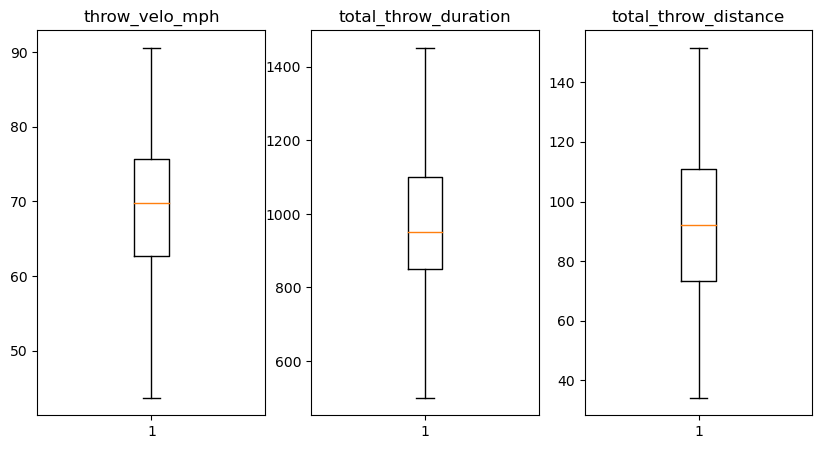

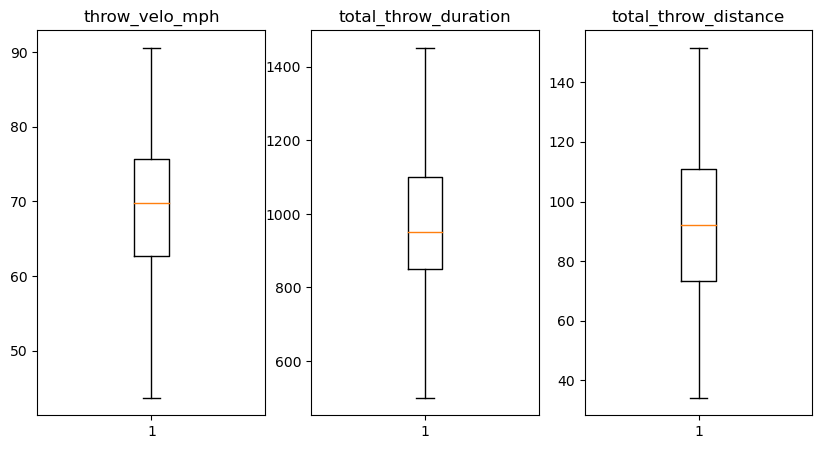

In [14]:
throw_time_df = throw_time_df[['player_id', 'player_position', 'throw_velo_mph', 'total_throw_duration', 'total_throw_distance', 'velo_3', 'distance_3D']]

def feature_box_plot(X):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.boxplot(throw_time_df['throw_velo_mph'])
    plt.title('throw_velo_mph')

    plt.subplot(1, 3, 2)
    plt.boxplot(throw_time_df['total_throw_duration'])
    plt.title('total_throw_duration')

    plt.subplot(1, 3, 3)
    plt.boxplot(throw_time_df['total_throw_distance'])
    plt.title('total_throw_distance')

feature_box_plot(throw_time_df)

# Use 1.5 IQR rule to remove outliers
def remove_outliers(X):
    Q1 = throw_time_df.quantile(0.25)
    Q3 = throw_time_df.quantile(0.75)
    IQR = Q3 - Q1
    return throw_time_df[~((throw_time_df < (Q1 - 1.5 * IQR)) |(throw_time_df > (Q3 + 1.5 * IQR))).any(axis=1)]

throw_time_df = remove_outliers(throw_time_df)

feature_box_plot(throw_time_df)

# Determine the most frequent position for each player
most_frequent_position = throw_time_df.groupby('player_id')['player_position'].agg(lambda x: x.value_counts().index[0]).reset_index()

# Calculate the maximum throw velocity for each player
max_player_throw_velo = throw_time_df.groupby('player_id')['throw_velo_mph'].max().reset_index()
max_player_throw_velo.rename(columns={'throw_velo_mph': 'max_throw_velo_mph'}, inplace=True)

# Merge the two DataFrames based on player_id
max_player_throw_velo = max_player_throw_velo.merge(most_frequent_position, on='player_id', how='inner')


max_player_throw_velo.to_csv('../../data/derived/throwtime/max_player_throw_velo_df.csv')
max_player_throw_velo.head()

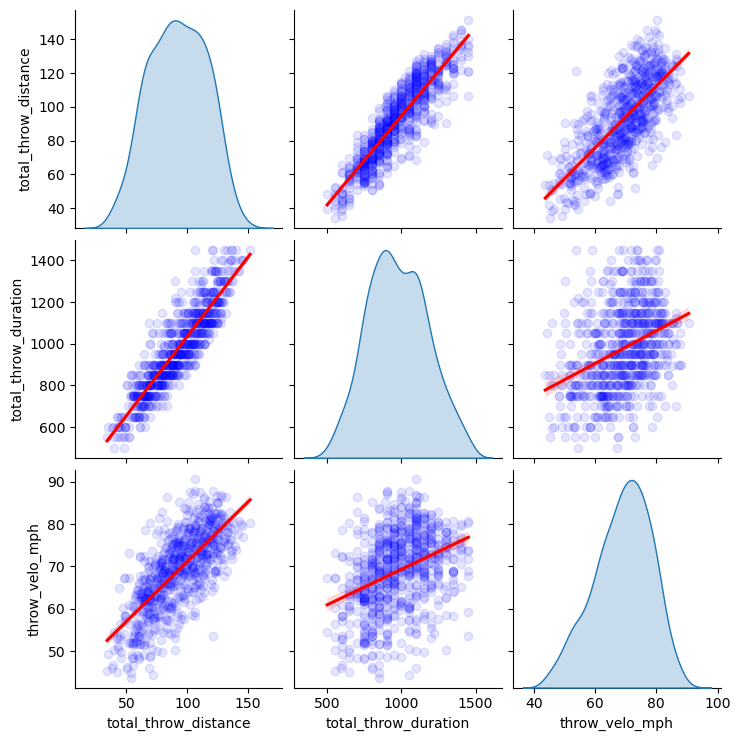

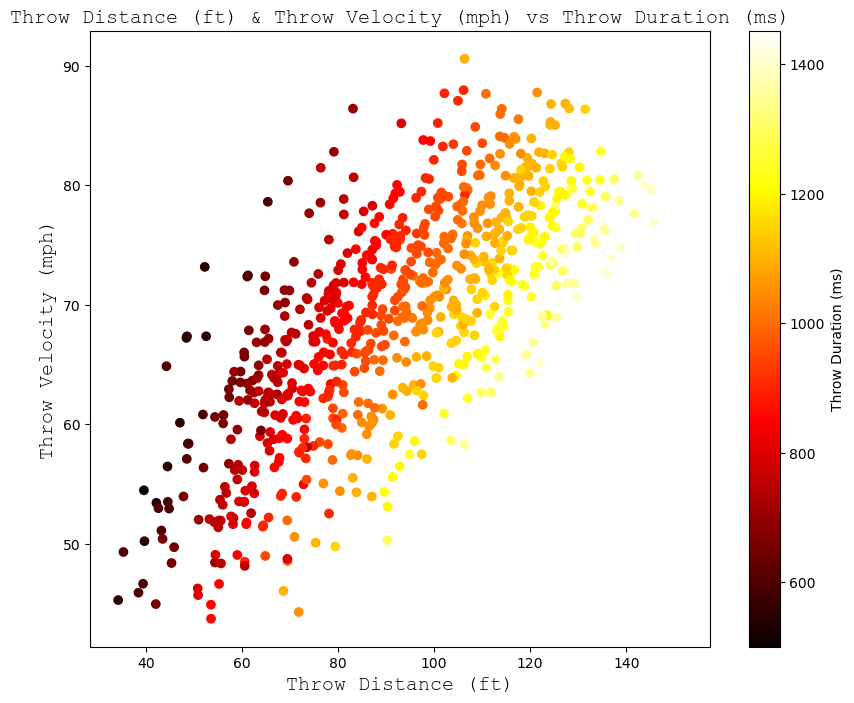

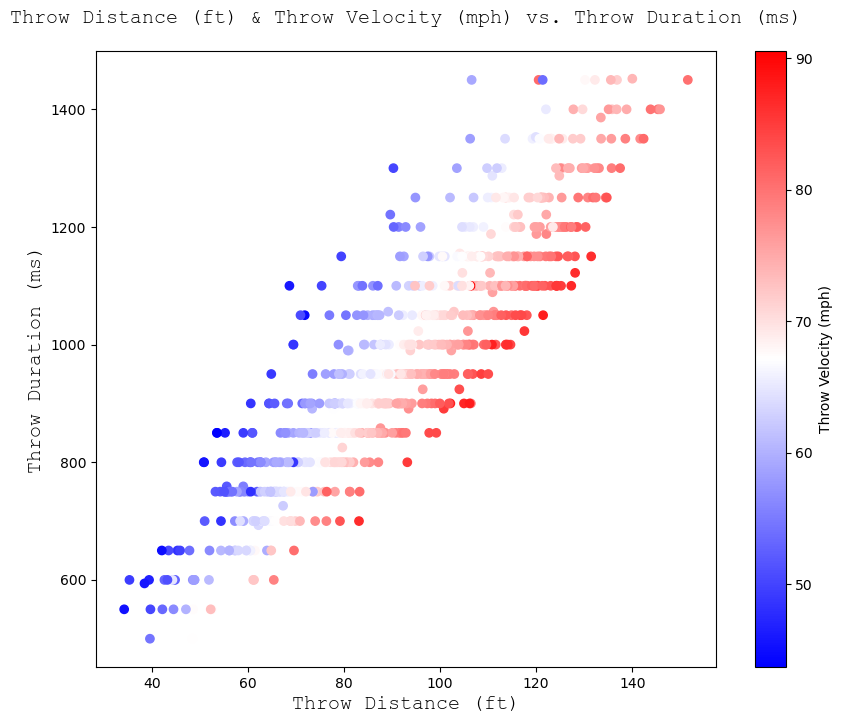

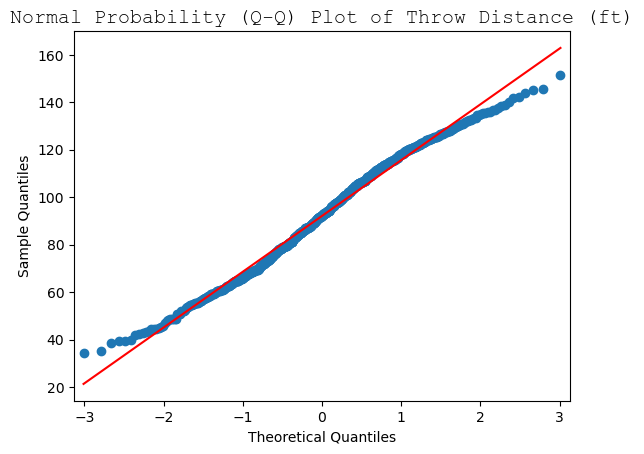

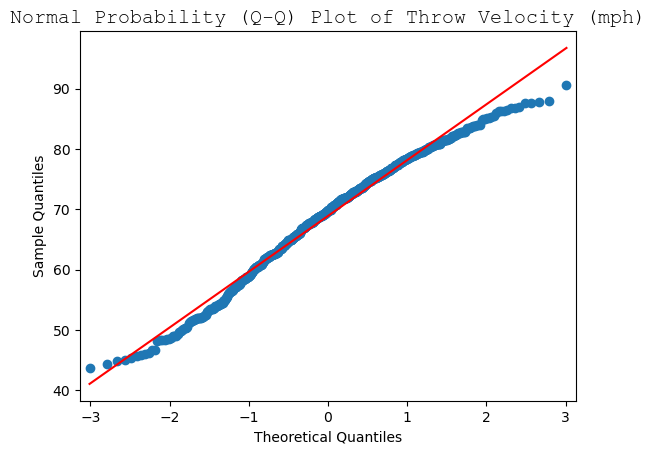

In [9]:
# Plot distance vs duration with throw_velo_mph as color for the throw_time_df throw_time_df as gb_ball_pos_df
title_font = {
    'family': 'courier new',
    'color': 'black',
    'weight': 'light',
    'size': 'x-large',
}

# Instead of showing every dot, show the density of the points using the size of the dot
sns.pairplot(throw_time_df, vars=['total_throw_distance', 'total_throw_duration', 'throw_velo_mph'], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 'color': 'blue'}})

plt.figure(figsize=(10, 8))
plt.scatter(x=throw_time_df['total_throw_distance'], y=throw_time_df['throw_velo_mph'], c=throw_time_df['total_throw_duration'], cmap='hot')
plt.colorbar(label='Throw Duration (ms)')
plt.xlabel('Throw Distance (ft)', fontdict=title_font)
plt.ylabel('Throw Velocity (mph)', fontdict=title_font)
plt.title('Throw Distance (ft) & Throw Velocity (mph) vs Throw Duration (ms)', fontdict=title_font)

plt.figure(figsize=(10, 8))
plt.scatter(x=throw_time_df['total_throw_distance'], y=throw_time_df['total_throw_duration'], c=throw_time_df['throw_velo_mph'], cmap='bwr')
plt.colorbar(label='Throw Velocity (mph)')
plt.xlabel('Throw Distance (ft)', fontdict=title_font)
plt.ylabel('Throw Duration (ms)', fontdict=title_font)
plt.title('Throw Distance (ft) & Throw Velocity (mph) vs. Throw Duration (ms)', fontdict=title_font, pad=20)

# Create normal probability plots for total_throw_distance and throw_velo_mph
fig_total_throw_distance = sm.qqplot(throw_time_df['total_throw_distance'], line='s')
plt.title('Normal Probability (Q-Q) Plot of Throw Distance (ft)', fontdict=title_font)

fig_throw_velo_mph = sm.qqplot(throw_time_df['throw_velo_mph'], line='s')
plt.title('Normal Probability (Q-Q) Plot of Throw Velocity (mph)', fontdict=title_font)  

plt.show()

(763, 2)
RMSE: 35.305349262920195
MAE: 21.856067166738903
['total_throw_distance' 'throw_velo_mph']
y = 11.17268248317329feature1-12.622118797222793feature2 + 816.0857628972752


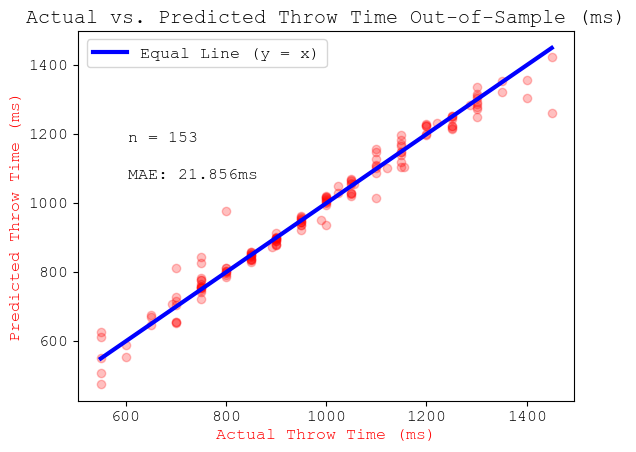

In [10]:
legend_font = {
    'family': 'courier new',  # Change to your desired font family
    'size': 10,              # Change to your desired font size
}

throw_time_lin_model = LinearRegression()

X = throw_time_df[['total_throw_distance', 'throw_velo_mph']]
y = throw_time_df['total_throw_duration']

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2002)

throw_time_lin_model.fit(X_train, y_train)

y_pred = throw_time_lin_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

legend_font = {
    'family': 'courier new',  # Change to your desired font family
    'size': 12,               # Change to your desired font size
}

# Set the custom font properties globally for the entire plot
plt.rc('font', **legend_font)


# print equation of line of best fit (there are two coefficients and one intercept)
print(throw_time_lin_model.feature_names_in_)
print('y = ' + str(throw_time_lin_model.coef_[0]) + 'feature1' + str(throw_time_lin_model.coef_[1]) + 'feature2' + ' + ' + str(throw_time_lin_model.intercept_))

# Create a plot
plt.scatter(y_test, y_pred, color='r', alpha=0.25)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], label='Equal Line (y = x)', color='blue', lw=3)
plt.text(0.1, 0.6, 'MAE: ' + str(round(mae, 3)) + 'ms', transform=plt.gca().transAxes)
plt.text(0.1, 0.7, 'n = ' + str(len(y_test)), transform=plt.gca().transAxes)
plt.xlabel('Actual Throw Time (ms)', color='r')
plt.ylabel('Predicted Throw Time (ms)', color='red')
plt.title('Actual vs. Predicted Throw Time Out-of-Sample (ms)')
plt.legend()

plt.show()

In [11]:
# Print the equation of the line
print(throw_time_lin_model.feature_names_in_)
print('y = ' + str(throw_time_lin_model.coef_[0]) + 'feature1' + str(throw_time_lin_model.coef_[1]) + 'feature2' + ' + ' + str(throw_time_lin_model.intercept_))

['total_throw_distance' 'throw_velo_mph']
y = 11.17268248317329feature1-12.622118797222793feature2 + 816.0857628972752


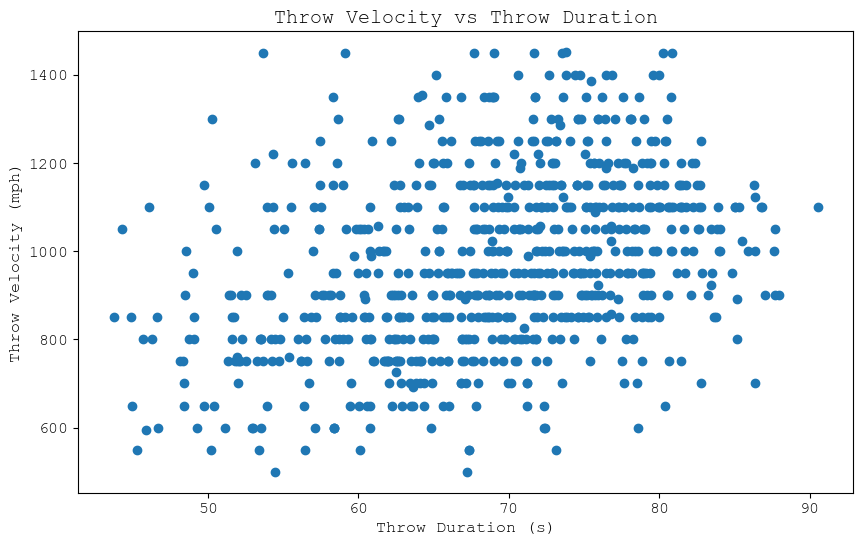

In [12]:
# Create smooth plot of throw_velo_mph vs total_throw_duration and throw_distance vs total_throw_duration
plt.figure(figsize=(10, 6))
plt.plot(throw_time_df['throw_velo_mph'], throw_time_df['total_throw_duration'], 'o')

plt.xlabel('Throw Duration (s)')
plt.ylabel('Throw Velocity (mph)')
plt.title('Throw Velocity vs Throw Duration')
plt.show()


In [13]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2002)

grid_space = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['distance', 'uniform'],
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    grid_space,
    cv=5,
    scoring='neg_mean_absolute_error',
)

# Do the grid search on X_scaled and report MAE
grid_search.fit(X_scaled, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best score: {best_score}')
print(f'Optimal hyper parameters:\n\tk = {best_params["n_neighbors"]}\n\taverage = {best_params["weights"]}')

# plot predictions vs actual for the optimal model
knn_model = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])
knn_model.fit(X_scaled_train, y_train)
y_pred = knn_model.predict(X_scaled_test)

Best score: -22.81652906776746
Optimal hyper parameters:
	k = 1
	average = uniform


In [14]:
# knn_model = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], weights='distance')

# knn_model.fit(X_scaled_train, y_train)

# y_pred_knn = knn_model.predict(X_scaled_test)

# # # Calculate residuals (differences between actual and predicted values)
# # residuals = y_test - y_pred_knn
# # # Calculate the standard error of the residuals (for calculating error bars)
# # std_residuals = np.std(residuals)
# # # Calculate confidence interval for the error bars (for a 95% confidence level)
# # confidence_level = 0.95
# # critical_value = 1.96  # For a 95% confidence level
# # error_bar = critical_value * (std_residuals / np.sqrt(len(y_test)))

# knn_rmse = mean_squared_error(y_test, y_pred_knn, squared=False)
# knn_mae = mean_absolute_error(y_test, y_pred_knn)

# print('knn_rmse:', knn_rmse)
# print('knn_mae:', knn_mae)

# legend_font = {
#     'family': 'courier new',  # Change to your desired font family
#     'size': 12,               # Change to your desired font size
# }

# # Set the custom font properties globally for the entire plot
# plt.rc('font', **legend_font)

# # Create a plot with error bars
# plt.scatter(y_test, y_pred_knn, color='r')
# # plt.errorbar(y_test, y_pred_knn, yerr=error_bar, fmt='none', color='cyan', alpha=0.5)
# plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred_knn, 1))(np.unique(y_test)), color='red', label='Least Squares Line', lw=3)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], label='Equal Line (y = x)', color='cyan', lw=3)
# plt.text(0.1, 0.6, 'MAE: ' + str(round(knn_mae, 2)) + 'ms', transform=plt.gca().transAxes)
# plt.text(0.1, 0.7, 'n = ' + str(len(y_test)), transform=plt.gca().transAxes)
# plt.xlabel('Actual Throw Time (ms)', color='r')
# plt.ylabel('Predicted Throw Time (ms)', color='red')
# plt.title('Actual vs. Predicted Throw Time Out-of-Sample (ms)')
# # In the bottom right show text of the best_params as k = n_neighbors
# plt.text(0.8775, 0.075, 'k = ' + str(best_params['n_neighbors']), transform=plt.gca().transAxes)
# plt.legend()

# # knn_mae: 22.290527201421227
# # knn_mae_unscaled: 21.797573750650347

In [15]:


# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = BaggingRegressor(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2001)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)  # Replace X and y with your data
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))





# base_estimator = DecisionTreeRegressor(random_state=2002)
# bagged_model = BaggingRegressor(estimator=base_estimator, n_estimators=150, random_state=2002, oob_score=True)

# grid_search = GridSearchCV(bagged_model, param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Extract best hyperparameters
# best_min_samples_split = grid_search.best_params_['base_estimator__min_samples_split']
# B
# # Create a new BaggingRegressor with the best hyperparameters
# best_bagged_model = BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_split=best_min_samples_split, random_state=2002),
#                                       n_estimators=150, random_state=2002, oob_score=True)

# # Model Training and Prediction
# best_bagged_model.fit(X_train, y_train)
# y_pred = best_bagged_model.predict(X_test)

# # Evaluate the model
# rmse_bag = rmse_scorer(y_test, y_pred)

# print("Best Hyperparameters:", grid_search.best_params_)
# print(f"Root Mean Squared Error: {rmse_bag:.2f}")
# print(f"OOB Score: {best_bagged_model.oob_score_:.2f}")

# plt.scatter(y_test, y_pred, color='r', alpha=0.25)
# plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red', label='Least Squares Line', lw=3)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], label='Equal Line (y = x)', color='cyan', lw=3)
# plt.text(0.1, 0.6, 'RMSE: ' + str(round(rmse_bag, 2)) + 'ms', transform=plt.gca().transAxes)
# plt.text(0.1, 0.7, 'n = ' + str(len(y_test)), transform=plt.gca().transAxes)
# plt.xlabel('Actual Throw Time (ms)', color='r')
# plt.ylabel('Predicted Throw Time (ms)', color='red')
# plt.title('Actual vs. Predicted Throw Time Out-of-Sample (ms)')
# plt.legend()

# plt.show()

# # bagged_tree_residuals

>10 -25.247 (3.087)
>50 -23.774 (3.523)
>100 -23.653 (3.234)
>500 -23.642 (3.273)
>1000 -23.655 (3.270)
>5000 -23.553 (3.277)
